In [38]:
# Import necessary libraries
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer     # to convert into a numeric matrix

# Get data
df = pd.read_csv("Realistic_Healthcare_Dataset.csv")

print(df)    # to check the data is loaded

                    Name  Age  Gender Blood Type Medical Condition  \
0           Jesus Mendez   58    Male         B+          Diabetes   
1         Kimberly Ortiz   47  Female         A+               Flu   
2           Cindy Ingram   61  Female         O+            Asthma   
3          Belinda James   77  Female         O-               Flu   
4      Lance Blankenship   45    Male         O+          Covid-19   
...                  ...  ...     ...        ...               ...   
55495       Heather Long   50  Female         A+           Obesity   
55496    Anthony Ramirez   92    Male         O+     Heart Disease   
55497     David Randolph   85  Female         O+          Diabetes   
55498      Carolyn Adams   46  Female         O-      Hypertension   
55499      Pamela Butler   46  Female         B-            Cancer   

      Date of Admission                Doctor                 Hospital  \
0            2023-03-23      Dr. Jared Thomas      Chen Medical Center   
1          

In [39]:
# ---------------------------
#  DATA CLEANING SECTION
# ---------------------------

# Standardize column names
df.columns = df.columns.str.strip()

# Convert date columns to datetime format
df['Date of Admission'] = pd.to_datetime(df['Date of Admission'], errors='coerce')
df['Discharge Date'] = pd.to_datetime(df['Discharge Date'], errors='coerce')

# Remove rows with missing or invalid dates
df = df.dropna(subset=['Date of Admission', 'Discharge Date'])

# Clean up inconsistent name capitalization
df['Name'] = df['Name'].str.title()

# Standardize text data (capitalize consistently)
df['Gender'] = df['Gender'].str.capitalize()
df['Blood Type'] = df['Blood Type'].str.upper()
df['Medical Condition'] = df['Medical Condition'].str.title()
df['Admission Type'] = df['Admission Type'].str.title()
df['Insurance Provider'] = df['Insurance Provider'].str.title()
df['Medication'] = df['Medication'].str.title()
df['Test Results'] = df['Test Results'].str.capitalize()

# Remove outliers in Billing Amount (optional: simple approach)
df = df[df['Billing Amount'] >= 0]  # Drop rows with negative billing amounts

# Add Length of Stay (new feature)
df['Length of Stay'] = (df['Discharge Date'] - df['Date of Admission']).dt.days

# Drop any remaining rows with critical missing data
df.dropna(inplace=True)

# Reset index after dropping rows
df.reset_index(drop=True, inplace=True)

# Quick check
print("Cleaned dataset shape:", df.shape)
print(df.head())


Cleaned dataset shape: (55500, 16)
                Name  Age  Gender Blood Type Medical Condition  \
0       Jesus Mendez   58    Male         B+          Diabetes   
1     Kimberly Ortiz   47  Female         A+               Flu   
2       Cindy Ingram   61  Female         O+            Asthma   
3      Belinda James   77  Female         O-               Flu   
4  Lance Blankenship   45    Male         O+          Covid-19   

  Date of Admission              Doctor                 Hospital  \
0        2023-03-23    Dr. Jared Thomas      Chen Medical Center   
1        2024-05-30  Dr. Marissa Jordan  Franklin Medical Center   
2        2020-07-05   Dr. Stephen Clark     Perez Medical Center   
3        2020-12-06  Dr. Jermaine Smith     Boyer Medical Center   
4        2021-08-09    Dr. Joel Fischer     Brown Medical Center   

       Insurance Provider  Billing Amount  Room Number Admission Type  \
0                Medicaid        24808.34          319         Urgent   
1  Blue Cross

In [40]:
# Show basic summary of data
summary_stats = df.describe()

print(summary_stats)

                Age              Date of Admission  Billing Amount  \
count  55500.000000                          55500    55500.000000   
mean      49.486775  2022-09-21 09:32:48.518918912    24092.372789   
min        0.000000            2020-03-20 00:00:00     5000.000000   
25%       37.000000            2021-06-20 00:00:00    17049.170000   
50%       50.000000            2022-09-21 00:00:00    23800.355000   
75%       62.000000            2023-12-25 00:00:00    30999.960000   
max       95.000000            2025-03-20 00:00:00    50440.640000   
std       17.875013                            NaN     9565.238835   

        Room Number                 Discharge Date  Length of Stay  
count  55500.000000                          55500    55500.000000  
mean     549.715333  2022-09-28 21:01:31.070270464        7.478270  
min      100.000000            2020-03-21 00:00:00        1.000000  
25%      328.000000            2021-06-27 00:00:00        4.000000  
50%      550.000000     

## Summary Results ##

Looking at the overall summary of the dataset, there are a few interesting points. The first is seen in the minimum row of the 'Billing Amount' column. The value is -2,008.49 rounded. As this is a billing amount in US dollars, this implies that the hospital owed the patient money. While this is not impossible, it does raise questions about why this occurred. In contrast, the average hospital bill was $25,539.32. In future analysis, we will examine a correlation between billing amount and medical condition as well as billing amount and test results.

When choosing my binary variable, there is only one: 'Gender'. After analyzing for a class imbalance, there is none present. There are roughly equal male vs female patients.

Dropdown(description='Select:', index=1, options=('Age Group', 'Gender', 'Blood Type'), value='Gender')

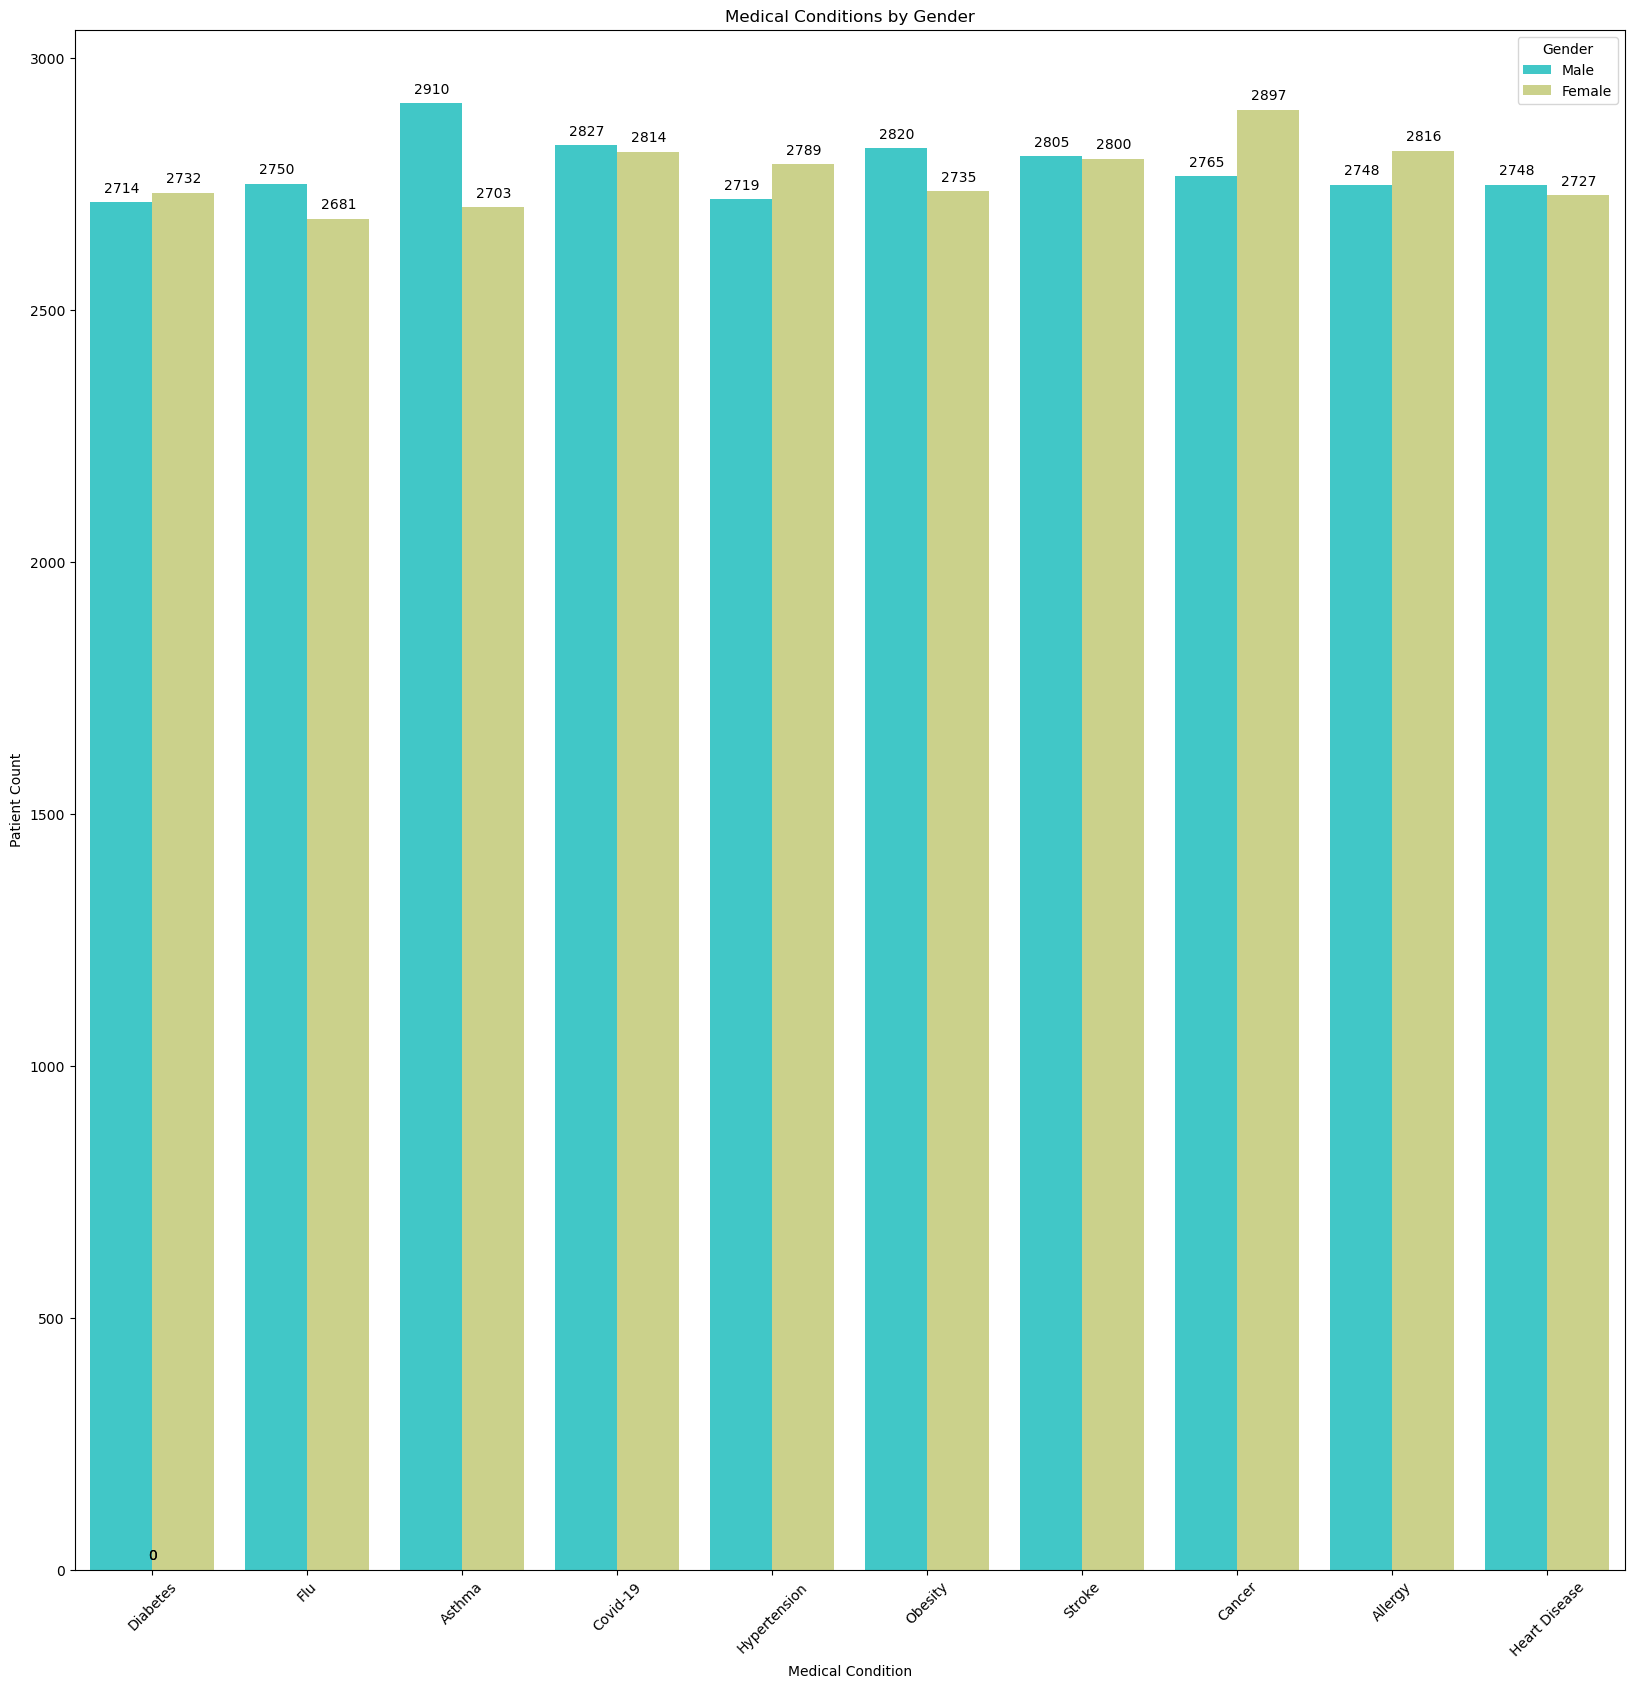

In [41]:
# Import additional required libraries
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Create a new column for age buckets (20-year intervals) to increase readability of the graphs
# "labels = " code section generated by chatGPT. I could not get the labels correctly formatted
df['Age Group'] = pd.cut(df['Age'], bins=range(0, 120, 20), right=False, labels=[f'{i}-{i+19}' for i in range(0, 100, 20)])

# Add in a dropdown filter for the user to interact with
dropdown = widgets.Dropdown(
    options = ['Age Group', 'Gender', 'Blood Type'],  # limiting the options to be user friendly and keep only relevant data
    value = 'Gender',  # Default value
    description = 'Select:',
    disabled = False,
)

# Implement the user's choice
def plot_MC(hue_variable):
    plt.figure(figsize = (20, 20))   # Larger plot size due to the size of the blood type graph
    ax = sns.countplot(x = 'Medical Condition', hue = hue_variable, data = df, palette = 'rainbow')  # Choosing rainbow color palette for both aesthetic and readability
    plt.title(f'Medical Conditions by {hue_variable}')   # Add title
    plt.xlabel('Medical Condition')    # X-axis label
    plt.ylabel('Patient Count')    # Y-axis label
    plt.legend(title = hue_variable)   # Add in the legend
    plt.xticks(rotation = 45)

    # Display the actual count values (solution created in collaboration with chatGPT)
    for p in ax.patches: # iterate through each bar
        ax.annotate(format(p.get_height(), '.0f'),  # add annotations, get height into string to find value
                    (p.get_x() + p.get_width() / 2., p.get_height()), # States where the text will be displayed (gotten by chatGPT)
                    ha = 'center', va = 'center', # Center the text
                    xytext = (0, 10), 
                    textcoords = 'offset points') # States that the text will be offset (not too sure. But it works)

    plt.show()    # Display the graph

# Created to allow the user to change the graph based on the filter (this did not work unless it was at the bottom)
def on_dropdown_change(change):
    clear_output(wait = True)  # To prevent the output from clearing immediately
    display(dropdown)
    plot_MC(change['new'])

# Combine
dropdown.observe(on_dropdown_change, names='value')

# Show plot and filter
display(dropdown)
plot_MC(dropdown.value)


/var/folders/bb/1cvnw_vn1rbc3y3x22_2_pqh0000gn/T/ipykernel_78829/2168471926.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'Medical Condition', y = 'Billing Amount', data = df, palette = 'rainbow')  # maintaining consistency with prior graphs


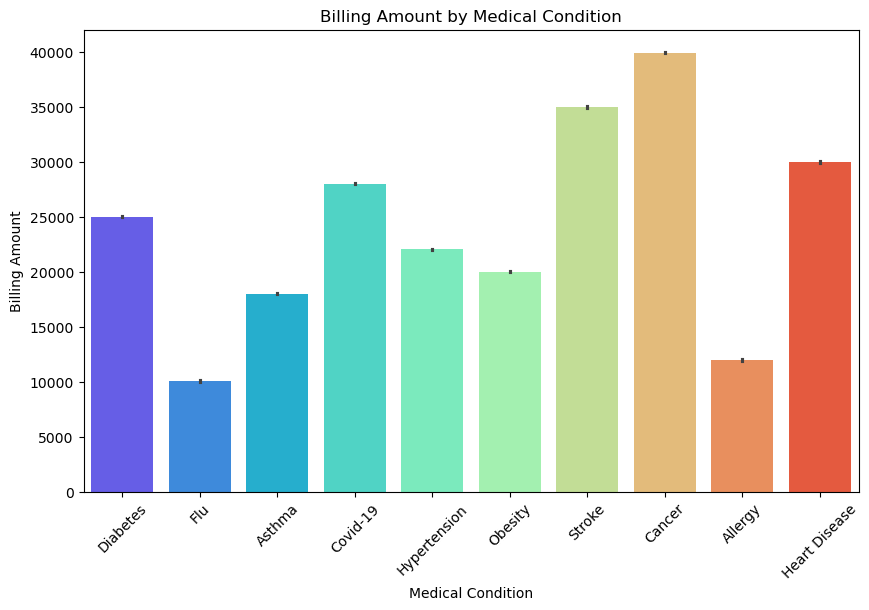

/var/folders/bb/1cvnw_vn1rbc3y3x22_2_pqh0000gn/T/ipykernel_78829/2168471926.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'Test Results', y = 'Billing Amount', data = df, palette = 'rainbow')    # maintaining consistency with prior graphs


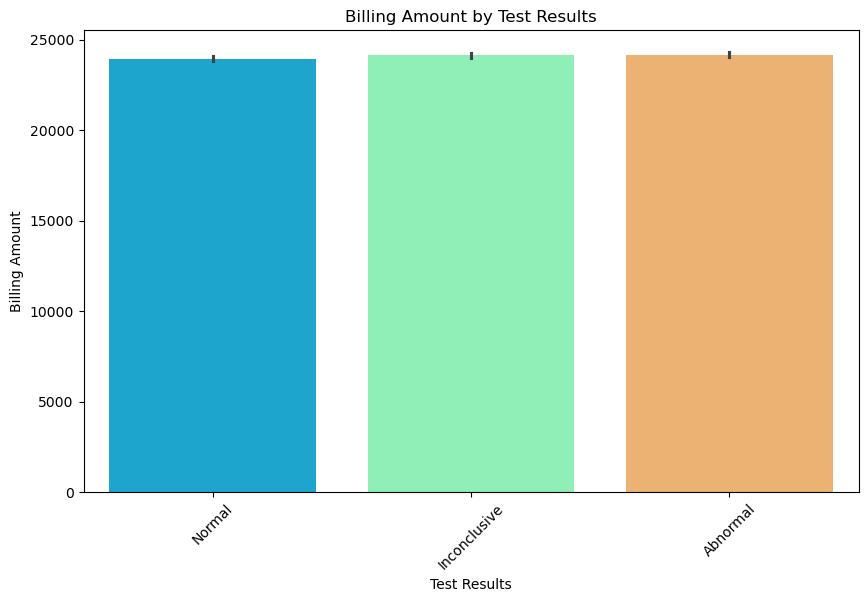

In [42]:
# Correlation between Medical Condition and Billing Amount
plt.figure(figsize = (10, 6))
sns.barplot(x = 'Medical Condition', y = 'Billing Amount', data = df, palette = 'rainbow')  # maintaining consistency with prior graphs
plt.title('Billing Amount by Medical Condition')
plt.xlabel('Medical Condition')
plt.ylabel('Billing Amount')
plt.xticks(rotation = 45)
plt.show()

# Correlation between Test Results and Billing Amount
plt.figure(figsize = (10, 6))
sns.barplot(x = 'Test Results', y = 'Billing Amount', data = df, palette = 'rainbow')    # maintaining consistency with prior graphs
plt.title('Billing Amount by Test Results')
plt.xlabel('Test Results')
plt.ylabel('Billing Amount')
plt.xticks(rotation = 45)
plt.show()

# Medical Condition Breakdown #

### Age Group ###

Starting with the Age Group graph, we can see that there are stark differences in the diagnosis by groups. The 20-79 year olds make up the majority of the dataset, which accounts for the large gap. Additionally, some conditions (such as Arthritis) are seen primarily in older patients, and rarely seen in younger patients. When it comes to obesity, we can note that the patients aged 40-59 have the highest diagnosis rate.

### Gender ###

Looking at the Gender graph, there appears to be very little difference between male and female patients when it comes to diagnosis. The only slightly notable difference is in asthma, where there are 79 more male patients with the diagnosis than female patients.

### Blood Type ###

In [43]:
# Import additional libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# Get target and explanatory variables
X_new = df[['Age', 'Gender', 'Blood Type']]
y_new = df['Medical Condition']

# Encode categorical variables
preprocessor_new = ColumnTransformer(
    transformers = [
        ('cat', OneHotEncoder(), ['Gender', 'Blood Type'])
    ],
    remainder = 'passthrough'    # do not transform other columns
)

# Split the data
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size = 0.2, random_state = 42)

# Create new pipeline
PL = Pipeline(steps = [
    ('preprocessor', preprocessor_new),
    ('classifier', DecisionTreeClassifier())
])

# Training
PL.fit(X_train_new, y_train_new)

# Predictions
Predictions = PL.predict(X_test_new)

# Evaluate the model
accuracy = accuracy_score(y_test_new, Predictions)
CLREP = classification_report(y_test_new, Predictions)

print("Accuracy:", accuracy)
print("Classification Report:")
print(CLREP)


Accuracy: 0.09603603603603604
Classification Report:
               precision    recall  f1-score   support

      Allergy       0.10      0.13      0.11      1061
       Asthma       0.12      0.13      0.12      1153
       Cancer       0.10      0.15      0.12      1121
     Covid-19       0.09      0.10      0.10      1090
     Diabetes       0.08      0.08      0.08      1064
          Flu       0.08      0.07      0.07      1163
Heart Disease       0.10      0.07      0.08      1099
 Hypertension       0.09      0.08      0.08      1077
      Obesity       0.11      0.09      0.10      1107
       Stroke       0.10      0.06      0.07      1165

     accuracy                           0.10     11100
    macro avg       0.10      0.10      0.09     11100
 weighted avg       0.10      0.10      0.09     11100



Age           0.005621
Gender        0.000709
Blood Type    0.004601
Medication    0.000348
Name: Medical Condition, dtype: float64


/var/folders/bb/1cvnw_vn1rbc3y3x22_2_pqh0000gn/T/ipykernel_78829/229807970.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_focus[column] = le.fit_transform(df_focus[column])
/var/folders/bb/1cvnw_vn1rbc3y3x22_2_pqh0000gn/T/ipykernel_78829/229807970.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_focus[column] = le.fit_transform(df_focus[column])
/var/folders/bb/1cvnw_vn1rbc3y3x22_2_pqh0000gn/T/ipykernel_78829/229807970.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

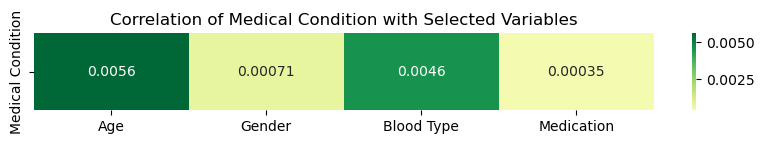

In [7]:
# Import additional libraries
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Selecting the relevant columns
df_focus = df[['Age', 'Gender', 'Blood Type', 'Medication', 'Medical Condition']]

# List of columns to encode
columns_to_encode = ['Gender', 'Blood Type', 'Medical Condition', 'Medication']

# Encode the categorical columns. I might switch to OneHotEncoders as there is not an order to the categorical data
label_encoders = {}
for column in columns_to_encode:
    le = LabelEncoder()
    df_focus[column] = le.fit_transform(df_focus[column])
    label_encoders[column] = le

# Compute the correlation matrix for the selected columns
correlation_matrix_focus = df_focus.corr()

# Extract the correlations for the specified columns
correlation_focus = correlation_matrix_focus.loc['Medical Condition', ['Age', 'Gender', 'Blood Type', 'Medication']]
print(correlation_focus)

# Convert to a DataFrame for heatmap plotting
correlation_focus_df = correlation_focus.to_frame().T

# Plotting the heatmap
plt.figure(figsize=(10, 1))
sns.heatmap(correlation_focus_df, annot=True, cmap='RdYlGn', center=0)
plt.title('Correlation of Medical Condition with Selected Variables')
plt.show()


## Correlations ##

As all of the values are close to 0, there does not appear to be any correlations between Age, Gender, Blood Type, or Medication and Medical Condition. Further analysis can give us a more accurate picture.

# Predicting Cancer Diagnosis Using Logistic Regression #

One way to improve patient care, and increase patient outcomes, is to determine if a patient is at risk of a condition before they begin showing signs of it. One of the best examples from this dataset is cancer. If we can predict whether a patient is at risk of cancer, we can attempt to intervene early with education and diagnostic testing. By catching cancer early, the patient has an increase chance of remission.

To do this, we will be looking at age, gender, and blood type.

In [18]:
from sklearn.linear_model import LogisticRegression

# Check the values for 'Test Result'. Should be Normal, Abnormal, and Inconclusive
print("Unique values in 'Test Results':")
print(df['Test Results'].unique())

# Remove the 'Inconclusive'. It is not helpful and I'm making this binary to do LR
df = df[df['Test Results'] != 'Inconclusive']

print(df.head())

# Convert to binary variable. Abnormal will flag as 1, and normal will be 0
df['Test Results'] = df['Test Results'].apply(lambda x: 1 if x == 'Abnormal' else 0)

# Get columns
df = df[['Medical Condition', 'Test Results']]

# Encode Medical Condition to be used in regression
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['Medical Condition'])
    ],
    remainder = 'passthrough'    # Leave other columns alone
)

# Get features and targets
X = df[['Medical Condition']]
y = df['Test Results']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify = y)

# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter = 1500))  # Iterate it a lot to get best fit
])

# Train the data
pipeline.fit(X_train, y_train)

# Get predictions
pred = pipeline.predict(X_test)

# Get accuracy and classification report
accuracy = accuracy_score(y_test, pred)
classification_report_result = classification_report(y_test, pred)

# Print Results
print("Accuracy: ", accuracy)
print("Classification Report: ")
print(classification_report_result)

Unique values in 'Test Results':
['Normal' 'Inconclusive' 'Abnormal']
                Name  Age  Gender Blood Type Medical Condition  \
0       Jesus Mendez   58    Male         B+          Diabetes   
2       Cindy Ingram   61  Female         O+            Asthma   
3      Belinda James   77  Female         O-               Flu   
4  Lance Blankenship   45    Male         O+          Covid-19   
5  Thomas Washington   45  Female         A+               Flu   

  Date of Admission              Doctor              Hospital  \
0        2023-03-23    Dr. Jared Thomas   Chen Medical Center   
2        2020-07-05   Dr. Stephen Clark  Perez Medical Center   
3        2020-12-06  Dr. Jermaine Smith  Boyer Medical Center   
4        2021-08-09    Dr. Joel Fischer  Brown Medical Center   
5        2022-08-31  Dr. Tiffany Malone   Dunn Medical Center   

  Insurance Provider  Billing Amount  Room Number Admission Type  \
0           Medicaid        24808.34          319         Urgent   
2     

In [19]:
# First, filter out 'Inconclusive' results
df = df[df['Test Results'] != 'Inconclusive']

# Convert to binary: Abnormal = 1, Normal = 0
df['Test Results'] = df['Test Results'].apply(lambda x: 1 if x == 'Abnormal' else 0)

# Check counts
print("Available class counts before sampling:")
print(df['Test Results'].value_counts())

# Sample 1000 rows with class balance (stratified sampling manually)
sample_size = 1000
class_0 = df[df['Test Results'] == 0].sample(n=sample_size // 2, random_state=42)
class_1 = df[df['Test Results'] == 1].sample(n=sample_size // 2, random_state=42)

df = pd.concat([class_0, class_1]).sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle

# Check final class balance
print("Class distribution in sample:")
print(df['Test Results'].value_counts())


Available class counts before sampling:
Test Results
0    37144
Name: count, dtype: int64


ValueError: a must be greater than 0 unless no samples are taken

In [32]:
# Filter out rows with 'Inconclusive' test results
df = df[df['Test Results'] != 'Inconclusive']

# Display counts after filtering out 'Inconclusive'
print("Counts after filtering 'Inconclusive' results:")
print(df['Test Results'].value_counts())

# Binarize 'Test Results' column (Normal=0, Abnormal=1)
df['Test Results'] = df['Test Results'].apply(lambda x: 1 if x == 'Abnormal' else 0)

# Check class distribution after binarizing
print("Class distribution after binarizing:")
print(df['Test Results'].value_counts())


Counts after filtering 'Inconclusive' results:
Test Results
Abnormal    18627
Normal      18517
Name: count, dtype: int64
Class distribution after binarizing:
Test Results
1    18627
0    18517
Name: count, dtype: int64


In [33]:
from sklearn.preprocessing import OneHotEncoder

# Select relevant columns
df = df[['Medical Condition', 'Test Results']]

# Encode the 'Medical Condition' variable using OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
X = encoder.fit_transform(df[['Medical Condition']])
y = df['Test Results']

# Check the shape of the data
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (37144, 10)
Shape of y: (37144,)


In [34]:
from sklearn.model_selection import train_test_split

# Split the data using stratified sampling to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check class distribution in training and test sets
print("Training set class distribution:")
print(y_train.value_counts())
print("Test set class distribution:")
print(y_test.value_counts())


Training set class distribution:
Test Results
1    14901
0    14814
Name: count, dtype: int64
Test set class distribution:
Test Results
1    3726
0    3703
Name: count, dtype: int64


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Check for any NaNs or infinite values in the dataset
print("Checking for NaNs in X_train:", np.isnan(X_train).any())
print("Checking for infinite values in X_train:", np.isinf(X_train).any())

# Train the Logistic Regression model directly with default parameters
model = LogisticRegression(max_iter=100)  # Reduce max_iter to simplify
model.fit(X_train, y_train)

# Get predictions
pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, pred)
classification_report_result = classification_report(y_test, pred)

# Print Results
print("Accuracy: ", accuracy)
print("Classification Report: ")
print(classification_report_result)


Checking for NaNs in X_train: False
Checking for infinite values in X_train: False
Accuracy:  0.4992596580966483
Classification Report: 
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      3703
           1       0.50      0.50      0.50      3726

    accuracy                           0.50      7429
   macro avg       0.50      0.50      0.50      7429
weighted avg       0.50      0.50      0.50      7429



In [44]:
from scipy.stats import f_oneway

# Ensure Length of Stay is calculated
if 'Length of Stay' not in df.columns:
    df['Date of Admission'] = pd.to_datetime(df['Date of Admission'])
    df['Discharge Date'] = pd.to_datetime(df['Discharge Date'])
    df['Length of Stay'] = (df['Discharge Date'] - df['Date of Admission']).dt.days


# Group billing amounts by medical condition
grouped_data = [group['Length of Stay'].values for name, group in df.groupby('Medical Condition')]

# Run ANOVA
anova_result = f_oneway(*grouped_data)

print("ANOVA Results:")
print("F-statistic:", anova_result.statistic)
print("p-value:", anova_result.pvalue)

# Interpretation
if anova_result.pvalue < 0.05:
    print("There is a statistically significant difference in length of stay across medical conditions.")
else:
    print("There is no statistically significant difference in length of stay across medical conditions.")


ANOVA Results:
F-statistic: 1.0698568927271006
p-value: 0.38138972870888715
There is no statistically significant difference in length of stay across medical conditions.


/var/folders/bb/1cvnw_vn1rbc3y3x22_2_pqh0000gn/T/ipykernel_78829/4078207495.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'Medical Condition', y = 'Billing Amount', data = df, palette = 'rainbow')


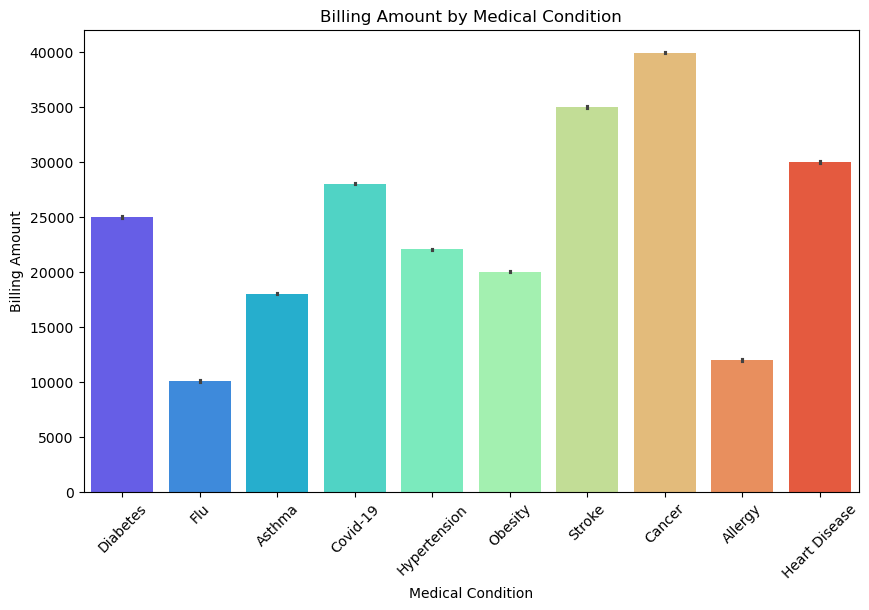

In [45]:
# Correlation between Medical Condition and Billing Amount
plt.figure(figsize = (10, 6))
sns.barplot(x = 'Medical Condition', y = 'Billing Amount', data = df, palette = 'rainbow')
plt.title('Billing Amount by Medical Condition')
plt.xlabel('Medical Condition')
plt.ylabel('Billing Amount')
plt.xticks(rotation = 45)
plt.show()

In [46]:
from scipy.stats import f_oneway

# Group billing amounts by medical condition
grouped_data = [group['Billing Amount'].values for name, group in df.groupby('Medical Condition')]

# Run ANOVA
anova_result = f_oneway(*grouped_data)

print("ANOVA Results:")
print("F-statistic:", anova_result.statistic)
print("p-value:", anova_result.pvalue)

# Interpretation
if anova_result.pvalue < 0.05:
    print("There is a statistically significant difference in billing amounts across medical conditions.")
else:
    print("There is no statistically significant difference in billing amounts across medical conditions.")


ANOVA Results:
F-statistic: 57910.57693839042
p-value: 0.0
There is a statistically significant difference in billing amounts across medical conditions.
